# Pseudo Virtual Fields: Neural Networks act as Taylor expansions to find optimal virtual fields via weak equilibrium minimization

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from helper_FEBIO import *
from VF_helper import *
from model import *
from plot_helper import *

In [4]:
import sys
sys.path.insert(0, '../')
from core import *
#config
from config import *
#CUDA
cuda=0
device=initCUDA(cuda)
#supporting files


-----------------------------------------------------
Setting device to:  0


/home/feolalab/anaconda3/envs/NNEUCLID/lib/python3.9/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647380992/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


Test:  cuda:0
-----------------------------------------------------



# Read FEBIO data

In [5]:

#Read connectivity
connectivity = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/connectivity")
connectivity

,1,1,9,513,107,44,117,603,368
0,2,9,10,514,513,117,118,604,603
1,3,10,11,515,514,118,119,605,604
2,4,11,12,516,515,119,120,606,605
3,5,12,13,517,516,120,121,607,606
4,6,13,14,518,517,121,122,608,607
...,...,...,...,...,...,...,...,...,...
994,996,1327,1328,354,355,598,599,95,94
995,997,1328,1329,353,354,599,600,96,95
996,998,1329,1330,352,353,600,601,97,96
997,999,1330,1331,351,352,601,602,98,97


### Function to read multiple states from FEBIO file

In [6]:
volume_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/volume"
volume=read_multi_ste_output2(volume_file,p=True) 

Detected 1-field blocks → ['element']
Number of states: 11
 State 1: element=1000
 State 2: element=1000
 State 3: element=1000
 State 4: element=1000
 State 5: element=1000
 State 6: element=1000
 State 7: element=1000
 State 8: element=1000
 State 9: element=1000
 State 10: element=1000
 State 11: element=1000


In [7]:
area_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/area"
area=read_multi_ste_output2(area_file,p=True) 

Detected 1-field blocks → ['element']
Number of states: 11
 State 1: element=600
 State 2: element=600
 State 3: element=600
 State 4: element=600
 State 5: element=600
 State 6: element=600
 State 7: element=600
 State 8: element=600
 State 9: element=600
 State 10: element=600
 State 11: element=600


In [8]:
stress_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/stress"
stress=read_multi_ste_output2(stress_file,p=True)

Detected 6-field blocks → ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']
Number of states: 11
 State 1: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 2: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 3: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 4: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 5: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 6: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 7: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 8: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 9: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 10: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 11: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000


In [9]:
F_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/F"
F=read_multi_ste_output2(F_file,p=True)

Detected 9-field blocks → ['F11', 'F12', 'F13', 'F21', 'F22', 'F23', 'F31', 'F32', 'F33']
Number of states: 11
 State 1: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=1000
 State 2: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=1000
 State 3: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=1000
 State 4: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=1000
 State 5: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=1000
 State 6: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=1000
 State 7: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=1000
 State 8: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=1000
 State 9: F11=1000, F12=1000, F13=1000, F21=1000, F22=1000, F23=1000, F31=1000, F32=1000, F33=100

In [10]:
surface_normal_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/surface_normal"
surface_normal=read_multi_ste_output2(surface_normal_file,p=True)

Detected 3-field blocks → ['x', 'y', 'z']
Number of states: 11
 State 1: x=600, y=600, z=600
 State 2: x=600, y=600, z=600
 State 3: x=600, y=600, z=600
 State 4: x=600, y=600, z=600
 State 5: x=600, y=600, z=600
 State 6: x=600, y=600, z=600
 State 7: x=600, y=600, z=600
 State 8: x=600, y=600, z=600
 State 9: x=600, y=600, z=600
 State 10: x=600, y=600, z=600
 State 11: x=600, y=600, z=600


In [11]:
position_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/position"
position=read_multi_ste_output2(position_file,p=True)

Detected 3-field blocks → ['x', 'y', 'z']
Number of states: 11
 State 1: x=1331, y=1331, z=1331
 State 2: x=1331, y=1331, z=1331
 State 3: x=1331, y=1331, z=1331
 State 4: x=1331, y=1331, z=1331
 State 5: x=1331, y=1331, z=1331
 State 6: x=1331, y=1331, z=1331
 State 7: x=1331, y=1331, z=1331
 State 8: x=1331, y=1331, z=1331
 State 9: x=1331, y=1331, z=1331
 State 10: x=1331, y=1331, z=1331
 State 11: x=1331, y=1331, z=1331


In [12]:
strain_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/lagrange_strain"
strain=read_multi_ste_output2(strain_file,p=True)

Detected 6-field blocks → ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']
Number of states: 11
 State 1: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 2: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 3: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 4: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 5: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 6: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 7: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 8: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 9: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 10: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000
 State 11: xx=1000, yy=1000, zz=1000, xy=1000, xz=1000, yz=1000


### Log file data

In [13]:
#Centroids from log file
centroids_file='/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/Model3.log'
centroids_dict  = parse_states(centroids_file)

#Should get 11 states, each with exactly 1000 x/y/z values:
print("states found:", sorted(centroids_dict.keys()))
for step, d in centroids_dict.items():
    print(f" step {step:2d}: x={len(d['x'])} pts, y={len(d['y'])}, z={len(d['z'])}")

states found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 step  0: x=1000 pts, y=1000, z=1000
 step  1: x=1000 pts, y=1000, z=1000
 step  2: x=1000 pts, y=1000, z=1000
 step  3: x=1000 pts, y=1000, z=1000
 step  4: x=1000 pts, y=1000, z=1000
 step  5: x=1000 pts, y=1000, z=1000
 step  6: x=1000 pts, y=1000, z=1000
 step  7: x=1000 pts, y=1000, z=1000
 step  8: x=1000 pts, y=1000, z=1000
 step  9: x=1000 pts, y=1000, z=1000
 step 10: x=1000 pts, y=1000, z=1000


### State dict to tensor

In [14]:
# 1) Build a (Nelements,3,nstates) tensor for centroids:
centroids_tensor = states_to_tensor(centroids_dict, ['x','y','z'])
print("centroids_tensor.shape:", centroids_tensor.shape)
# → (Nelements, 3, nstates)

# 2) Build a (Nelements,6,nstates) tensor for volume‐stress:
stress_tensor = states_to_tensor(stress,
                                ['xx','yy','zz','xy','xz','yz'])
print("stress_tensor.shape:", stress_tensor.shape)
# → (Nelements, 6, nstates)

# 3) If you just want the x‐only channel across states:
#x_only = states_to_tensor(centroids_dict, ['x'])
#print("x_only.shape:", x_only.shape)
# → (Nelements, 1, nstates)

# 3) Volume:
volume_tensor = states_to_tensor(volume, ['element'])
print("volume_tensor.shape:", volume_tensor.shape)
# → (Nelements, 1, nstates)

# 4) Deformation tensor:
F_tensor = states_to_tensor(F, ['F11','F12','F13','F21','F22','F23','F31','F32','F33'])
print("F_tensor.shape:", F_tensor.shape)

# 4) Surface Normal:
surface_normal_tensor = states_to_tensor(surface_normal, ['x','y','z'])
print("surface_normal_tensor.shape:", surface_normal_tensor.shape)


# 5) Area:
area_tensor = states_to_tensor(area, ['element'])
print("area_tensor.shape:", area_tensor.shape)


# 6) Strain:
#del strain[1]
strain_tensor = states_to_tensor(strain, ['xx','yy','zz','xy','xz','yz'])
print("strain_tensor.shape:", strain_tensor.shape)

centroids_tensor.shape: torch.Size([1000, 3, 11])
stress_tensor.shape: torch.Size([1000, 6, 11])
volume_tensor.shape: torch.Size([1000, 1, 11])
F_tensor.shape: torch.Size([1000, 9, 11])
surface_normal_tensor.shape: torch.Size([600, 3, 11])
area_tensor.shape: torch.Size([600, 1, 11])
strain_tensor.shape: torch.Size([1000, 6, 11])


In [15]:
torch.sum(centroids_tensor[:,:,0], dim=(0,1))

tensor(0., dtype=torch.float32)

In [16]:
centroids_tensor[500, :,0]

tensor([0., 0., 0.], dtype=torch.float32)

In [17]:
Nelements=F_tensor.shape[0]

## Where pressure is applied and Zero Displacement Boundary Conditions

In [18]:
pressure_nodes = parse_quad4_from_feb("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/Model3.feb", surface_name="Pressure1")
pressure_node_ids = list(pressure_nodes.keys())

In [19]:
pressure_nodes[1], type(pressure_nodes)

([5, 35, 522, 108], dict)

In [20]:
ZD_nodes = parse_quad4_from_feb("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/Model3.feb", surface_name="ZeroDisplacement1")
ZD_node_ids = list(ZD_nodes.keys())

In [21]:
ZD_nodes[1], len(ZD_node_ids)

([4, 80, 441, 99], 100)

In [22]:
connectivity_list = [
    tuple(map(int, row))           # ensure ints
    for row in connectivity.values
]

In [23]:
# 2) Flatten pressure-node dict into a set of node IDs
pressure_nodes_set = {
    n
    for nodes in pressure_nodes.values()
    for n in nodes
}

mapping_element_pressure = map_pressure_to_elements(connectivity_list, pressure_nodes_set)
#print(mapping.keys())
# (3) inspect
for eid, info in mapping_element_pressure.items():
    print(f"Element {eid}:")
    print("  all_nodes:     ", info['all_nodes'])
    print("  pressure_nodes:", info['pressure_nodes'])

Element 901:
  all_nodes:      [36, 189, 1251, 440, 5, 35, 522, 108]
  pressure_nodes: [5, 35, 522, 108]
Element 902:
  all_nodes:      [189, 190, 1252, 1251, 35, 34, 523, 522]
  pressure_nodes: [35, 34, 523, 522]
Element 903:
  all_nodes:      [190, 191, 1253, 1252, 34, 33, 524, 523]
  pressure_nodes: [34, 33, 524, 523]
Element 904:
  all_nodes:      [191, 192, 1254, 1253, 33, 32, 525, 524]
  pressure_nodes: [33, 32, 525, 524]
Element 905:
  all_nodes:      [192, 193, 1255, 1254, 32, 31, 526, 525]
  pressure_nodes: [32, 31, 526, 525]
Element 906:
  all_nodes:      [193, 194, 1256, 1255, 31, 30, 527, 526]
  pressure_nodes: [31, 30, 527, 526]
Element 907:
  all_nodes:      [194, 195, 1257, 1256, 30, 29, 528, 527]
  pressure_nodes: [30, 29, 528, 527]
Element 908:
  all_nodes:      [195, 196, 1258, 1257, 29, 28, 529, 528]
  pressure_nodes: [29, 28, 529, 528]
Element 909:
  all_nodes:      [196, 197, 1259, 1258, 28, 27, 530, 529]
  pressure_nodes: [28, 27, 530, 529]
Element 910:
  all_node

In [24]:
# 2) Flatten pressure-node dict into a set of node IDs
ZD_nodes_set = {
    n
    for nodes in ZD_nodes.values()
    for n in nodes
}

mapping_element_ZD = map_pressure_to_elements(connectivity_list, ZD_nodes_set)
#print(mapping.keys())
# (3) inspect
for eid, info in mapping_element_ZD.items():
    print(f"Element {eid}:")
    print("  all_nodes:     ", info['all_nodes'])
    print("  pressure_nodes:", info['pressure_nodes'])

Element 2:
  all_nodes:      [9, 10, 514, 513, 117, 118, 604, 603]
  pressure_nodes: [9, 10, 514, 513]
Element 3:
  all_nodes:      [10, 11, 515, 514, 118, 119, 605, 604]
  pressure_nodes: [10, 11, 515, 514]
Element 4:
  all_nodes:      [11, 12, 516, 515, 119, 120, 606, 605]
  pressure_nodes: [11, 12, 516, 515]
Element 5:
  all_nodes:      [12, 13, 517, 516, 120, 121, 607, 606]
  pressure_nodes: [12, 13, 517, 516]
Element 6:
  all_nodes:      [13, 14, 518, 517, 121, 122, 608, 607]
  pressure_nodes: [13, 14, 518, 517]
Element 7:
  all_nodes:      [14, 15, 519, 518, 122, 123, 609, 608]
  pressure_nodes: [14, 15, 519, 518]
Element 8:
  all_nodes:      [15, 16, 520, 519, 123, 124, 610, 609]
  pressure_nodes: [15, 16, 520, 519]
Element 9:
  all_nodes:      [16, 17, 521, 520, 124, 125, 611, 610]
  pressure_nodes: [16, 17, 521, 520]
Element 10:
  all_nodes:      [17, 2, 45, 521, 125, 18, 198, 611]
  pressure_nodes: [17, 2, 45, 521]
Element 11:
  all_nodes:      [107, 513, 504, 106, 368, 603, 

In [25]:
pressure_element_IDs=list(mapping_element_pressure.keys())

pressure_element_IDs_final = torch.tensor([nid - 1 for nid in pressure_element_IDs], dtype=torch.long)

#len(pressure_element_IDs_final)

In [26]:
ZD_element_IDs=list(mapping_element_ZD.keys())

ZD_element_IDs_final = torch.tensor([nid - 1 for nid in ZD_element_IDs], dtype=torch.long)

#len(pressure_element_IDs_final)

In [27]:
ZD_element_IDs_final, ZD_element_IDs

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
         55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
         91, 92, 93, 94, 95, 96, 97, 98, 99]),
 [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94

In [28]:

#Get normals of surfaces where pressure is applied
# 1) zero‐based indices for those nodes:
idx = torch.tensor([nid - 1 for nid in pressure_node_ids], dtype=torch.long)
idx_ZD = torch.tensor([nid - 1 for nid in ZD_node_ids], dtype=torch.long)

# 2) index into the first dimension:
#    result has shape (100, 3, 11)
pressure_normals = surface_normal_tensor[idx, :, :]
area_normals = area_tensor[idx, :, :]

#ZD:
ZD_normals = surface_normal_tensor[idx_ZD, :, :]
ZD_areas = area_tensor[idx_ZD, :, :]


print(pressure_normals.shape)  # → torch.Size([100, 3, 11])
print(ZD_normals.shape)  # → torch.Size([100, 3, 11])

torch.Size([100, 3, 11])
torch.Size([100, 3, 11])


In [29]:
#print("VF.shape =", VF.shape)
print("max idx =", max(pressure_element_IDs_final).item())
print("min idx =", min(pressure_element_IDs_final).item())


max idx = 999
min idx = 900


# Architecture

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
del model

NameError: name 'model' is not defined

In [32]:
from model import *

vf_number=2 #linear elastic is 2 parameters
model = ICNN3D_Taylor_multifield_with_neg(n_input=3,
                n_hidden=[64,64,64],
                n_output=30,
                use_dropout=True,
                dropout_rate=0.2,
                centroids=True, p_fields=vf_number)

In [33]:
from torchinfo import summary
model = model.to(device)
summary(model)

Layer (type:depth-idx)                   Param #
ICNN3D_Taylor_multifield_with_neg        --
├─ModuleDict: 1-1                        --
│    └─Linear: 2-1                       448
│    └─Linear: 2-2                       4,160
│    └─Linear: 2-3                       4,160
│    └─Linear: 2-4                       3,900
├─ModuleDict: 1-2                        --
│    └─Linear: 2-5                       448
│    └─Linear: 2-6                       448
│    └─Linear: 2-7                       420
├─AdaptiveAvgPool1d: 1-3                 --
Total params: 13,984
Trainable params: 13,984
Non-trainable params: 0

## Training loop

In [34]:
F_tensor.shape, stress_tensor.shape, centroids_tensor.shape

(torch.Size([1000, 9, 11]),
 torch.Size([1000, 6, 11]),
 torch.Size([1000, 3, 11]))

In [35]:
x_input= torch.cat(( F_tensor.to(device),centroids_tensor.to(device)), dim=1)
#x_input= F_tensor.to(device)
x_input.shape

torch.Size([1000, 12, 11])

In [ ]:
stress_tensor_3d=Voigt_to_3d(stress_tensor)

In [37]:
model.apply(init_weights)

ICNN3D_Taylor_multifield_with_neg(
  (layers): ModuleDict(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=60, bias=True)
  )
  (skip_layers): ModuleDict(
    (1): Linear(in_features=6, out_features=64, bias=True)
    (2): Linear(in_features=6, out_features=64, bias=True)
    (3): Linear(in_features=6, out_features=60, bias=True)
  )
  (global_pooling): AdaptiveAvgPool1d(output_size=1)
)

In [38]:

def evaluate_vf_values(V_NN: torch.Tensor, delta_xyz: torch.Tensor):
    """
    Evaluate p global Taylor‐expanded virtual fields at N points.

    Args:
        V_NN       (torch.Tensor): shape [p, 30], Taylor coefficients for p fields
        delta_xyz  (torch.Tensor): shape [N,  3], the (x,y,z) offsets

    Returns:
        torch.Tensor: shape [p, N, 3], where each slice [k] is the (Vx,Vy,Vz)
                      values of the k+th virtual field at all N points.
    """
    # Split out the 10‐wide blocks for Vx, Vy, Vz respectively
    Vx_coeff = V_NN[:,  0:10]   # [p,10]
    Vy_coeff = V_NN[:, 10:20]
    Vz_coeff = V_NN[:, 20:30]

    # Build the N×10 design matrix of monomials
    x, y, z = delta_xyz[:,0], delta_xyz[:,1], delta_xyz[:,2]
    B = torch.stack([
        torch.ones_like(x),
        x, y, z,
        x**2, y**2, z**2,
        x*y, x*z, y*z
    ], dim=1)  # [N,10]

    # Multiply coefficients by monomials: (p×10) @ (10×N) → (p×N)
    Vx_vals = Vx_coeff @ B.T
    Vy_vals = Vy_coeff @ B.T
    Vz_vals = Vz_coeff @ B.T

    # Stack into (p, N, 3)
    return torch.stack([Vx_vals, Vy_vals, Vz_vals], dim=2)


In [39]:
import torch

def construct_VF_gradients_batch(V_NN: torch.Tensor, delta_xyz: torch.Tensor) -> torch.Tensor:
    """
    Vectorized gradient of p global Taylor‐expanded VFs at N points.

    Args:
        V_NN       (torch.Tensor): shape [p, 30], Taylor coefficients for p VFs
        delta_xyz  (torch.Tensor): shape [N,  3], the (x,y,z) offsets

    Returns:
        torch.Tensor: shape [p, N, 3, 3], where
                      out[k,i] is the 3×3 gradient tensor of the k-th VF at point i.
    """
    p, coeff_len = V_NN.shape
    N, _         = delta_xyz.shape
    if coeff_len != 30:
        raise ValueError(f"Expected V_NN with 30 coefficients, got {coeff_len}")

    # Prepare delta for broadcasting: [1, N]
    dx = delta_xyz[:, 0].unsqueeze(0)
    dy = delta_xyz[:, 1].unsqueeze(0)
    dz = delta_xyz[:, 2].unsqueeze(0)

    # Split into Vx, Vy, Vz coefficient blocks [p,10]
    a = V_NN[:,  0:10]
    b = V_NN[:, 10:20]
    c = V_NN[:, 20:30]

    # Helper to extract and unsqueeze a given index
    def e(block, idx):
        return block[:, idx].unsqueeze(1)  # [p,1]

    # Extract and unsqueeze needed coeffs
    a1,a2,a3 = e(a,1), e(a,2), e(a,3)
    a4,a5,a6 = e(a,4), e(a,5), e(a,6)
    a7,a8,a9 = e(a,7), e(a,8), e(a,9)
    b1,b2,b3 = e(b,1), e(b,2), e(b,3)
    b4,b5,b6 = e(b,4), e(b,5), e(b,6)
    b7,b8,b9 = e(b,7), e(b,8), e(b,9)
    c1,c2,c3 = e(c,1), e(c,2), e(c,3)
    c4,c5,c6 = e(c,4), e(c,5), e(c,6)
    c7,c8,c9 = e(c,7), e(c,8), e(c,9)

    # Compute partials [p,N]
    dVx_dx = +a1 + 2*a4*dx +    a7*dy +    a8*dz
    dVx_dy = +a2 +    a7*dx + 2*a5*dy +    a9*dz
    dVx_dz = +a3 +    a8*dx +    a9*dy + 2*a6*dz

    dVy_dx = +b1 + 2*b4*dx +    b7*dy +    b8*dz
    dVy_dy = +b2 +    b7*dx + 2*b5*dy +    b9*dz
    dVy_dz = +b3 +    b8*dx +    b9*dy + 2*b6*dz

    dVz_dx = +c1 + 2*c4*dx +    c7*dy +    c8*dz
    dVz_dy = +c2 +    c7*dx + 2*c5*dy +    c9*dz
    dVz_dz = +c3 +    c8*dx +    c9*dy + 2*c6*dz

    # Stack into [p,N,3,3]
    grad = torch.stack([
        torch.stack([dVx_dx, dVx_dy, dVx_dz], dim=2),
        torch.stack([dVy_dx, dVy_dy, dVy_dz], dim=2),
        torch.stack([dVz_dx, dVz_dy, dVz_dz], dim=2)
    ], dim=2)

    return grad


#### Train
If we keep the strain pointwise throughout the solid we can get a map of parameters...

In [67]:
epoch=500
# Adam with a learning rate:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#Number of states:
states=x_input.shape[2]
N_pressure_dofs=len(pressure_element_IDs_final)
N_ZD_dofs=len(ZD_element_IDs_final)
#loss_list=[]
keys = ['Internal', 'External', 'ZD','Special']
#work_dict = { key: [] for key in keys }
for i in range(epoch):
    optimizer.zero_grad()#reset gradients
    loss = torch.zeros((), device=device)    # scalar, same dtype/device
    #Estimate
    for s in range(1,states):
        V_NN=model(x_input[:,:,s]) #This is VF,30

        delta_xyz=calculate_point(centroids_tensor, s) #This is N elements x3

        VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 
        
        
        grad_VF= construct_VF_gradients_batch(V_NN, delta_xyz) #This is p,N,3,3 . 

        #Strain
        virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3))

        #Volume integral:
        # element‐wise inner product σ^e : ∇v^e
        integrand = torch.sum(stress_tensor_3d[:,:,:,s].unsqueeze(0) * virtual_strain, dim=(2, 3)) # → shape [p,N]
       # print(f'Integrand shape: {integrand.shape}')
        W_int = torch.sum(integrand * volume_tensor[:,0,s].unsqueeze(0) ,dim=(0,1))/(Nelements*vf_number)

       # print(f'W_int shape: {W_int.shape}')
        #Surface integral
        t_surface=pressure_normals[:,:,s]*10000 #t_surface is N,3 (elements x xyz)
     #   print(f'W_int shape: {W_int.shape}')
        dot = (VF_values[:,pressure_element_IDs_final,:]* t_surface.unsqueeze(0)).sum(dim=2)  # shape: [3, 100]

        W_ext=torch.sum(dot*area_normals[:,:,s].T,dim=(0,1))/(N_pressure_dofs*vf_number)

        ## Add ZD term:
        ZD_regularization=torch.sum(VF_values[:,ZD_element_IDs_final,:]**2, dim=(0,1,2))/(N_ZD_dofs*vf_number)


        ## SPECIAL VIRTUAL FIELDS
        # 1) Extract normal & shear strains from strain_tensor (Voigt):
        ε_xx = strain_tensor[:, 0, s] #.detach().cpu().numpy()   # (1000,)
        ε_yy = strain_tensor[:, 1,s]#.detach().cpu().numpy()
        ε_zz = strain_tensor[:, 2,s]#.detach().cpu().numpy()
        ε_xy = strain_tensor[:, 3,s]#.detach().cpu().numpy()
        ε_yz = strain_tensor[:, 4,s]#.detach().cpu().numpy()
        ε_zx = strain_tensor[:, 5,s]#.detach().cpu().numpy()

        # 2) Extract corresponding dotted strains from virtual_strain:
        εd_xx = virtual_strain[:,:, 0, 0]
        εd_yy = virtual_strain[:,:, 1, 1]
        εd_zz = virtual_strain[:,:, 2, 2]
        εd_xy = virtual_strain[:,:, 0, 1]  # = virtual_strain[:,1,0]
        εd_yz = virtual_strain[:,:, 1, 2]  # = virtual_strain[:,2,1]
        εd_zx = virtual_strain[:,:, 2, 0]  # = virtual_strain[:,0,2]


        #Now the A matrix:

        A1= (ε_xx+ε_yy+ε_zz)*(εd_xx+εd_yy+εd_zz)* volume_tensor[:,0,s]
        A2= (ε_xx * εd_xx + ε_yy * εd_yy +ε_zz * εd_zz +2 * (ε_xy * εd_xy +ε_yz * εd_yz +ε_zx * εd_zx))* volume_tensor[:,0,s]

       # print(A1.sum().item())
        #print(A2.sum().item())
#
        A = torch.stack([A1, A2], dim=1)  # -> (1000,6)
        M = A.mean(dim=2)                   # shape (2, 2):  M[k] = [ I_v^(k), I_d^(k) ]

      #  print(A.sum().item())
        # 1) make a [6,6,1] identity tensor

        I = torch.eye(2, device=A.device) #.unsqueeze(2)   # now I.shape == (6,6,1)

        # 2) subtract it from each slice of A
        A_minus_I = A.mean(dim=2)*1e5 - I   # broadcasts I to (6,6,1000)
        #print(A_minus_I.sum().item())
        
        special_loss = torch.sum(A_minus_I**2)

        #Loss:
        loss+=(W_int-W_ext)**2+ZD_regularization+special_loss*0.1

    loss/=states
    loss_list.append(loss.item())
    work_dict['Internal'].append(W_int.item())
    work_dict['External'].append(W_ext.item())
    work_dict['ZD'].append(ZD_regularization.item())

    if i % 50 == 0:
        W_int_item = W_int.item()
        W_ext_item = W_ext.item()
        ZD_regularization_item= ZD_regularization.item()
        special_loss_item= special_loss.item()
        L_item    = loss.item()
        print(
            f"Epoch {i:4d} │ "
            f"W_int (internal work): {W_int_item: .2e} │ "
            f"W_ext (external work): {W_ext_item: .2e} │ "
            f"Zero Displacement term: {ZD_regularization_item: .2e} │ "
            f"Special Loss term: {special_loss_item: .4e} │ "
            f"Loss: {L_item: .2e}"
        )

    loss.backward()

    optimizer.step()

Epoch    0 │ W_int (internal work): -1.87e-01 │ W_ext (external work): -1.53e-01 │ Zero Displacement term:  1.31e-01 │ Special Loss term:  1.0738e+00 │ Loss:  1.31e+00
Epoch   50 │ W_int (internal work): -1.53e-01 │ W_ext (external work): -1.75e-01 │ Zero Displacement term:  1.20e-01 │ Special Loss term:  1.0907e+00 │ Loss:  1.28e+00
Epoch  100 │ W_int (internal work): -1.27e-01 │ W_ext (external work): -1.36e-01 │ Zero Displacement term:  1.06e-01 │ Special Loss term:  1.1182e+00 │ Loss:  1.25e+00
Epoch  150 │ W_int (internal work): -6.34e-02 │ W_ext (external work):  6.05e-03 │ Zero Displacement term:  8.76e-02 │ Special Loss term:  1.1411e+00 │ Loss:  1.23e+00
Epoch  200 │ W_int (internal work): -3.27e-02 │ W_ext (external work):  6.64e-02 │ Zero Displacement term:  6.42e-02 │ Special Loss term:  1.1798e+00 │ Loss:  1.21e+00
Epoch  250 │ W_int (internal work): -4.05e-02 │ W_ext (external work): -2.42e-01 │ Zero Displacement term:  3.07e-02 │ Special Loss term:  1.2380e+00 │ Loss:  1

In [68]:
print_vf_equations(V_NN[0], fmt="{:+.3f}")

Vx(x,y,z) = -0.003*1 + -0.235*x + +0.023*y + +0.277*z + -0.045*x**2 + -0.036*x*y + -0.634*x*z + +0.025*y**2 + +1.794*y*z + -0.571*z**2
Vy(x,y,z) = -0.036*1 + -0.008*x + -0.092*y + +0.400*z + +0.087*x**2 + +0.014*x*y + -0.116*x*z + +0.010*y**2 + -0.051*y*z + -0.582*z**2
Vz(x,y,z) = +0.029*1 + -0.044*x + -0.011*y + +0.116*z + +0.052*x**2 + -0.227*x*y + +0.150*x*z + -0.136*y**2 + -0.012*y*z + +0.047*z**2


In [44]:
print_vf_equations(V_NN[1], fmt="{:+.3f}")

Vx(x,y,z) = -0.029*1 + +0.119*x + -0.032*y + +0.291*z + +0.580*x**2 + -0.505*x*y + +0.134*x*z + -0.414*y**2 + -0.047*y*z + -0.874*z**2
Vy(x,y,z) = +0.289*1 + -0.232*x + -0.234*y + -0.074*z + -0.240*x**2 + -0.128*x*y + -0.069*x*z + +0.196*y**2 + -0.141*y*z + +0.163*z**2
Vz(x,y,z) = +0.005*1 + -0.144*x + -0.182*y + +0.368*z + +0.323*x**2 + +0.166*x*y + -0.359*x*z + -0.780*y**2 + -0.235*y*z + +0.214*z**2


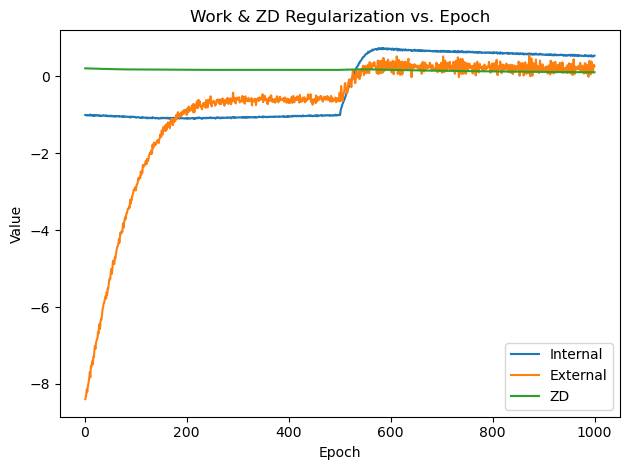

In [47]:
import matplotlib.pyplot as plt

# assume work_dict already exists, with lists of length N for each key
epochs = list(range(1, len(work_dict['Internal']) + 1))

plt.figure()
plt.plot(epochs, work_dict['Internal'], label='Internal')
plt.plot(epochs, work_dict['External'], label='External')
plt.plot(epochs, work_dict['ZD'], label='ZD')
#plt.plot(epochs, work_dict['Special'], label='Special')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Work & ZD Regularization vs. Epoch')

plt.legend()
plt.tight_layout()
plt.show()


## Export

In [48]:
model.eval()
time_idx=9

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)

In [49]:
for i in range(vf_number):
    tensor1 = VF_values[i,:,:].cpu()        # shape [1000,3]

    name='multi_VF_'+str(i)+'.txt'
    with open(name,'w') as f:
        for i, (x, y, z) in enumerate(tensor1.tolist(), start=1):
            f.write(f"{i},{x},{y},{z}\n")


# Parameter Recovery

In [50]:
model.eval()
time_idx=9

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)
#Vz=construct_VF(V_NN[20:30],delta_xyz)

#VF=torch.cat((Vx.unsqueeze(1),Vy.unsqueeze(1),Vz.unsqueeze(1)), dim=1)
grad_VF= construct_VF_gradients_batch(V_NN, delta_xyz)

#Strain
virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3)).detach().cpu().numpy()

In [51]:
V_NN.shape

torch.Size([2, 30])

In [52]:
print_vf_equations(V_NN[0], fmt="{:+.3f}")

Vx(x,y,z) = +0.023*1 + -0.049*x + -0.017*y + +0.271*z + -0.086*x**2 + -0.254*x*y + +0.455*x*z + -0.344*y**2 + +0.130*y*z + -0.284*z**2
Vy(x,y,z) = +0.249*1 + -0.084*x + -0.414*y + +0.038*z + +0.172*x**2 + +0.309*x*y + -0.271*x*z + -0.069*y**2 + +0.013*y*z + +0.230*z**2
Vz(x,y,z) = -0.064*1 + +0.219*x + +0.324*y + +0.254*z + -0.139*x**2 + +0.018*x*y + -0.343*x*z + -0.849*y**2 + -0.198*y*z + +0.008*z**2


In [53]:
print_vf_equations(V_NN[1], fmt="{:+.3f}")

Vx(x,y,z) = -0.029*1 + +0.118*x + -0.033*y + +0.291*z + +0.579*x**2 + -0.504*x*y + +0.136*x*z + -0.413*y**2 + -0.048*y*z + -0.877*z**2
Vy(x,y,z) = +0.288*1 + -0.232*x + -0.235*y + -0.074*z + -0.239*x**2 + -0.129*x*y + -0.069*x*z + +0.196*y**2 + -0.140*y*z + +0.163*z**2
Vz(x,y,z) = +0.006*1 + -0.144*x + -0.180*y + +0.369*z + +0.322*x**2 + +0.166*x*y + -0.359*x*z + -0.779*y**2 + -0.234*y*z + +0.214*z**2


In [54]:
VF_values.shape

torch.Size([2, 1000, 3])

In [60]:
#Surface integral
t_surface=pressure_normals[:,:,s]*10000 #t_surface is N,3 (elements x xyz)
#   print(f'W_int shape: {W_int.shape}')
dot = (VF_values[:,pressure_element_IDs_final,:]* t_surface.unsqueeze(0)).sum(dim=2)  # shape: [3, 100]

W_ext=(dot*area_normals[:,:,s].T)

In [63]:
W_ext.shape, W_ext.mean(dim=1)/(1.27*1e-7)

(torch.Size([2, 100]),
 tensor([ 54421752., -52926372.], dtype=torch.float32, grad_fn=<DivBackward0>))

In [62]:
M

tensor([[ 1.2740e-07,  5.7640e-10],
        [-1.1111e-08,  1.4529e-07]], dtype=torch.float32,
       grad_fn=<MeanBackward1>)